# FeatureEstimationDemo

### Read example BIDS data 

In this demo the basic offline workflow of py_neuromodulation will be demonstrated. For that, the example BIDS dataset in *pyneuromodulation/tests/data/* will be analyzed. 
The respective `settings.json` are stored in *examples/settings.json*, the `df_M1.csv` is created given the *channel_type* information from the BIDS data. 

A projection will be defined based on the *examples/grid_cortex.tsv* and *examples/grid_subcortex.tsv* files. Band power features and sharpwave features will then be estimated and projected to the provided grid. 

First, necessary modules will be included and the BIDS_PATH and RUN_PATH, the path to the BIDS brainvision run file, will be defined given the example.

In [1]:
import sys
from bids import BIDSLayout
from matplotlib import pyplot as plt
import os
from scipy import io
import numpy as np
import json
from pathlib import Path
import scipy

# first parent to get example folder, second py_neuromodulation folder
PATH_PYNEUROMODULATION = Path("__file__").absolute().parent.parent  # "__file__" required for ipynb
sys.path.append(os.path.join(PATH_PYNEUROMODULATION, 'pyneuromodulation'))
sys.path.append(os.path.join(Path("__file__").absolute().parent.parent,'examples'))

import start_BIDS
import settings as nm_settings
import IO
import define_M1
import features
import generator
import rereference
import resample
import run_analysis
import normalization
import projection

print("current working directory: " + os.getcwd())
print("PATH_PYNEUROMODULATION: " + str(PATH_PYNEUROMODULATION))
BIDS_EXAMPLE_PATH = os.path.abspath(os.path.join(PATH_PYNEUROMODULATION, 'pyneuromodulation',
                                    'tests', 'data'))

# write BIDS example path in settings.json
with open(os.path.join(os.pardir, 'examples', 'settings.json'), encoding='utf-8') as json_file:
    settings = json.load(json_file)
settings["BIDS_path"] = BIDS_EXAMPLE_PATH

# write relative feature output folder
settings["out_path"] = os.path.abspath(os.path.join(PATH_PYNEUROMODULATION, 'pyneuromodulation',
                                    'tests', 'data', 'derivatives'))
with open(os.path.abspath(os.path.join(os.pardir, 'examples', 'settings.json')), 'w') as f:
    json.dump(settings, f, indent=4)

PATH_RUN = os.path.join(BIDS_EXAMPLE_PATH, 'sub-testsub', 'ses-EphysMedOff',
                        'ieeg', "sub-testsub_ses-EphysMedOff_task-buttonpress_ieeg.vhdr")

print("\nused run path: " + str(PATH_RUN))

current working directory: C:\Users\ICN_admin\Documents\py_neuromodulation\sphinx
PATH_PYNEUROMODULATION: C:\Users\ICN_admin\Documents\py_neuromodulation

used run path: C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\tests\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_ieeg.vhdr


Next, the used settings will be read, and mne-bids will be used to read the example data.

In [2]:
os.chdir(os.path.join(os.pardir,'pyneuromodulation'))
sys.path.append(os.path.join(os.pardir,'examples'))

# read and test settings first to obtain BIDS path
settings_wrapper = nm_settings.SettingsWrapper(settings_path=os.path.join(os.pardir, 'examples', 'settings.json'))

# read BIDS data
raw_arr, raw_arr_data, fs, line_noise = IO.read_BIDS_data(PATH_RUN, settings_wrapper.settings["BIDS_path"])

# read df_M1 / create M1 if None specified
settings_wrapper.set_M1(m1_path=None, ch_names=raw_arr.ch_names,
                        ch_types=raw_arr.get_channel_types())
settings_wrapper.set_fs_line_noise(fs, line_noise)

Reading settings.json.
Testing settings.
No Error occurred when testing the settings.
Extracting parameters from C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\tests\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\tests\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_channels.tsv.
Reading in coordinate system frame Other: None.
Reading electrode coords from C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\tests\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.
The read in electrodes file is: 
 [('name', ['ECOG_AT_SM_L_1', 'ECOG_AT_SM_L_2', 'ECOG_AT_SM_L_3', 'ECOG_AT_SM_L_4', 'ECOG_AT_SM_L_5', 'ECOG_AT_SM_L_6', 'LFP_STN_R_234', 'LFP_STN_R_567', 'LFP_BS_STN_L_1', 'LFP_STN_L_234', 'LFP_STN_L_567

C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\IO.py:32: RuntimeWarning: Did not find any events.tsv associated with sub-testsub_ses-EphysMedOff_task-buttonpress.

The search_str was "C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\tests\data\sub-testsub\**\sub-testsub_ses-EphysMedOff*events.tsv"
  raw_arr = mne_bids.read_raw_bids(bids_path)
C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\IO.py:32: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw_arr = mne_bids.read_raw_bids(bids_path)
C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\IO.py:32: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['ANALOG_ROT_R_1']
  raw_arr = mne_bids.read_raw_bids(bids_path)
C:\Users\ICN_admin\Documents\py_neuromodulation\pyneuromodulation\IO.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw

Let's check the specified df_M1 dataframe: 

In [3]:
settings_wrapper.df_M1

,name,rereference,used,target,type,status,new_name
0,LFP_STN_R_234,LFP_STN_R_567,1,0,seeg,good,LFP_STN_R_234-LFP_STN_R_567
1,LFP_STN_R_567,LFP_STN_R_234,1,0,seeg,good,LFP_STN_R_567-LFP_STN_R_234
2,LFP_BS_STN_L_1,LFP_STN_L_567,1,0,seeg,good,LFP_BS_STN_L_1-LFP_STN_L_567
3,LFP_STN_L_234,LFP_BS_STN_L_1,1,0,seeg,good,LFP_STN_L_234-LFP_BS_STN_L_1
4,LFP_STN_L_567,LFP_STN_L_234,1,0,seeg,good,LFP_STN_L_567-LFP_STN_L_234
5,ECOG_AT_SM_L_1,average,1,0,ecog,good,ECOG_AT_SM_L_1-avgref
6,ECOG_AT_SM_L_2,average,1,0,ecog,good,ECOG_AT_SM_L_2-avgref
7,ECOG_AT_SM_L_3,average,1,0,ecog,good,ECOG_AT_SM_L_3-avgref
8,ECOG_AT_SM_L_4,average,1,0,ecog,good,ECOG_AT_SM_L_4-avgref
9,ECOG_AT_SM_L_5,average,1,0,ecog,good,ECOG_AT_SM_L_5-avgref


We can see that the data contains depth LFP electrodes from the Subthalamic Nucleus and a ECoG strip. Bipolar rereferencing was defined for the depth electrodes, and common average rereference for the ECoG electrodes. 
Importantly *ANALOG_ROT_R_1* is used as a target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features. 

Next we will check the used settings:

In [4]:
settings_wrapper.settings

{'BIDS_path': 'C:\\Users\\ICN_admin\\Documents\\py_neuromodulation\\pyneuromodulation\\tests\\data',
 'out_path': 'C:\\Users\\ICN_admin\\Documents\\py_neuromodulation\\pyneuromodulation\\tests\\data\\derivatives',
 'sampling_rate_features': 10,
 'methods': {'raw_resampling': True,
  'raw_normalization': True,
  'feature_normalization': True,
  'kalman_filter': True,
  're_referencing': True,
  'notch_filter': True,
  'bandpass_filter': True,
  'raw_hjorth': True,
  'sharpwave_analysis': True,
  'return_raw': True,
  'project_cortex': True,
  'project_subcortex': False,
  'pdc': False,
  'dtf': False},
 'raw_resampling_settings': {'resample_freq': 1000},
 'raw_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'kalman_filter_settings': {'Tp': 0.1,
  'sigma_w': 0.7,
  'sigma_v': 1,
  'frequency_bands': ['low gamma', 'high gamm

Many signal processing and feature estimation parameters are here defined. Most importantly the `settings_wrapper.setttings["methods"]` tells us which signal processing and features should be estimated: 

In [5]:
settings_wrapper.settings["methods"]

{'raw_resampling': True,
 'raw_normalization': True,
 'feature_normalization': True,
 'kalman_filter': True,
 're_referencing': True,
 'notch_filter': True,
 'bandpass_filter': True,
 'raw_hjorth': True,
 'sharpwave_analysis': True,
 'return_raw': True,
 'project_cortex': True,
 'project_subcortex': False,
 'pdc': False,
 'dtf': False}

As defined, data will be **resampled**, **normalized** and **rereferenced** (as defined in the df_M1) before feature estimation. Then, **bandpower features**, **sharpwave features** and **hjorth parameters** are calculated. Additionally, gamma band features will be Kalman filtered. Since *project_cortex* is set to true, projection to a grid is also enabled. 

### Grid projection

Next we will read the cortical grid, defined in *examples/grid_cortex.tsv*, and calculate the **projection matrices** from individual channels to the grid:

In [6]:
if settings_wrapper.settings["methods"]["project_cortex"] is True or \
    settings_wrapper.settings["methods"]["project_subcortex"] is True:
    settings_wrapper.add_coord(raw_arr.copy())  # if not copy ch_names is being set
    projection_ = projection.Projection(settings_wrapper.settings)
else:
    projection_ = None

In [7]:
settings_wrapper.settings["methods"]["project_cortex"]

True

We can now inspect the individual coordinates, and the projected grid points. Therfore we read first a standard MNI hull, defined in the plot folder:

In [8]:
PATH_PLOT =os.path.join(os.pardir, 'plots')
faces = io.loadmat(os.path.join(PATH_PLOT, 'faces.mat'))
vertices = io.loadmat(os.path.join(PATH_PLOT, 'Vertices.mat'))
grid = io.loadmat(os.path.join(PATH_PLOT, 'grid.mat'))['grid']
x_ecog = vertices['Vertices'][::1,0]
y_ecog = vertices['Vertices'][::1,1]
z_ecog = vertices['Vertices'][::1,2]

Since the grid is defined for the left hemisphere, we might switch the x coordinates for right electrodes. Then the ECoG channel coordinates (crosses) and used grid points (circles) are visualized:  

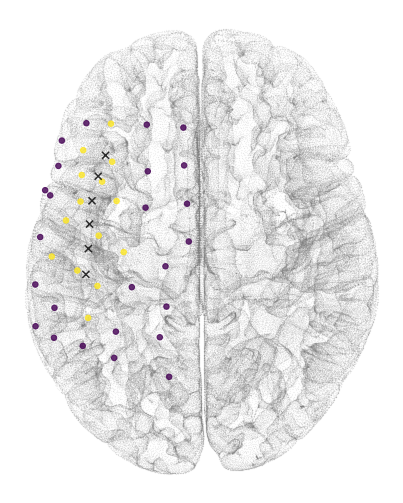

In [9]:
cortex_grid = np.array(projection_.grid_cortex.T)

if settings_wrapper.settings["sess_right"] is True:
    cortex_grid[0,:] = cortex_grid[0,:]*-1
    ecog_strip = np.array(settings_wrapper.settings["coord"]["cortex_right"]["positions"]).T
else:
    ecog_strip = np.array(settings_wrapper.settings["coord"]["cortex_left"]["positions"]).T


fig, axes = plt.subplots(1,1, facecolor=(1,1,1), \
                        figsize=(14,9))#, dpi=300)
axes.scatter(x_ecog, y_ecog, c="gray", s=0.001)
axes.axes.set_aspect('equal', anchor='C')

grid_color = projection_.proj_matrix_cortex.sum(axis=1)
pos_ecog = axes.scatter(cortex_grid[0,:],
                        cortex_grid[1,:], c=grid_color, 
                        s=30, alpha=0.8, cmap="viridis")

pos_elec = axes.scatter(ecog_strip[0,:],
                        ecog_strip[1,:], c=np.ones(ecog_strip.shape[1]), 
                        s=50, alpha=0.8, cmap="gray", marker="x")
plt.axis('off')
plt.show()

As visible, only grid points are active (channel data is projected unto them as shown in yellow) within the *max_dist* of every individual channel for the cortical and subcortical grid. 

Next, the **rereference** and **resample** classes get instantiated, and an acquisition system is simulated by a **generator**:

In [10]:
# initialize generator for run function
gen = generator.ieeg_raw_generator(raw_arr_data, settings_wrapper.settings)

# initialize rereferencing
if settings_wrapper.settings["methods"]["re_referencing"] is True:
    rereference_ = rereference.RT_rereference(settings_wrapper.df_M1, split_data=False)
else:
    rereference_ = None

    
# define resampler for faster feature estimation
if settings_wrapper.settings["methods"]["raw_resampling"] is True:
    resample_ = resample.Resample(settings_wrapper.settings)
else:
    resample_ = None

### Feature Estimation 

Now the used **feature** and **run_analysis** classes are instantiated. Here FIR Filters and Kalman Filters are parametrized. During online feature estimation filters only have to be applied, instead of a repetitive calculatation, which in turn saves computational time. 

In [11]:
# initialize feature class from settings
features_ = features.Features(settings_wrapper.settings)

# initialize run object
run_analysis_ = run_analysis.Run(features_, settings_wrapper.settings,
                                 rereference_, projection_, resample_, verbose=True)

Segment lengths (ms): [1000  500  333  333  333  100  100  100]
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 10.00 Hz)
- Filter length: 999 samples (0.999 sec)

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

Given the previously initialized generator, we can now receive a first data batch of 1 sec in shape (channels, samples): 

In [61]:
ieeg_batch = next(gen, None)

In [62]:
ieeg_batch.shape

(12, 1375)

This allows us to estimate the previously assigned features:

In [63]:
if ieeg_batch is not None:
    run_analysis_.run(ieeg_batch)

1.6 seconds of data processed
Last batch took: 0.18 seconds


In [64]:
run_analysis_.feature_arr

,LFP_STN_R_234-LFP_STN_R_567_bandpass_activity_theta,LFP_STN_R_234-LFP_STN_R_567_bandpass_mobility_theta,LFP_STN_R_234-LFP_STN_R_567_bandpass_complexity_theta,LFP_STN_R_234-LFP_STN_R_567_bandpass_activity_alpha,LFP_STN_R_234-LFP_STN_R_567_bandpass_mobility_alpha,LFP_STN_R_234-LFP_STN_R_567_bandpass_complexity_alpha,LFP_STN_R_234-LFP_STN_R_567_bandpass_activity_low beta,LFP_STN_R_234-LFP_STN_R_567_bandpass_mobility_low beta,LFP_STN_R_234-LFP_STN_R_567_bandpass_complexity_low beta,LFP_STN_R_234-LFP_STN_R_567_bandpass_activity_high beta,...,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_width,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_prominence,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_interval,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_decay_time,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_rise_time,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_sharpness,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_rise_steepness,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_decay_steepness,ECOG_AT_SM_L_6-avgref_Sharpwave_Max_Trough_slope_ratio,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.0
1,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,...,NaN,1.000000,NaN,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,1100.0
2,-1.413856,0.986026,1.411066,0.719298,-1.413113,1.002520,-1.002182,0.939468,1.407790,-1.375475,...,NaN,0.742469,NaN,-0.707107,-0.707107,0.438655,-0.288772,1.027999,-0.849363,1200.0
3,-1.133993,1.628242,-1.522077,0.867106,-1.000275,-0.947065,-0.823012,1.531718,0.160493,-1.519733,...,NaN,0.825928,NaN,-0.577350,-0.577350,0.578837,0.001586,1.134153,-0.937460,1300.0
4,-0.564420,1.496153,-1.568611,1.630299,-0.830257,-1.045311,-0.752502,1.376794,-0.327432,-1.099329,...,NaN,0.916122,NaN,-0.500000,-0.500000,0.717736,0.287253,1.217577,-1.027123,1400.0
5,-0.032050,0.917335,-0.947647,1.491794,-0.463283,-1.449514,-0.746026,1.142843,-0.476464,-0.895653,...,NaN,1.000204,NaN,-0.447214,-0.447214,0.842543,0.555343,1.278756,-1.104789,1500.0
6,1.794198,0.037151,-1.286162,1.157103,-1.207859,-1.193593,1.422738,-0.561030,1.380136,1.524448,...,-2.44949,-2.377112,NaN,2.445754,-2.448673,-2.358675,-2.405600,-2.408255,2.379510,1600.0


As seen above already 1629 features are calculated based on this data batch. For every analyzed data batch, a subsequent row is appended to the run_analysis_.feature_arr. Let's show some features for a signle channel: 

In [65]:
ch = 'ECOG_AT_SM_L_1'
ch_cols = [f_ for f_ in run_analysis_.feature_arr.columns if ch in f_]

In [66]:
run_analysis_.feature_arr[ch_cols].T

,0,1,2,3,4,5,6
ECOG_AT_SM_L_1-avgref_bandpass_activity_theta,0.0,1.0,-1.053859,-1.320893,-1.707613,-1.412793,-1.375319
ECOG_AT_SM_L_1-avgref_bandpass_mobility_theta,0.0,1.0,-0.636474,-1.729447,-1.689738,-1.865972,-0.103034
ECOG_AT_SM_L_1-avgref_bandpass_complexity_theta,0.0,1.0,1.378971,1.507552,1.774458,1.834773,0.517982
ECOG_AT_SM_L_1-avgref_bandpass_activity_alpha,0.0,-1.0,-1.250933,-0.990942,-1.491038,-1.133773,-0.926004
ECOG_AT_SM_L_1-avgref_bandpass_mobility_alpha,0.0,-1.0,-1.076922,0.368802,1.763838,1.307799,-0.853319
...,...,...,...,...,...,...,...
ECOG_AT_SM_L_1-avgref_Sharpwave_Max_Trough_rise_time,0.0,NaN,NaN,NaN,NaN,NaN,-2.449490
ECOG_AT_SM_L_1-avgref_Sharpwave_Max_Trough_sharpness,0.0,1.0,1.087625,1.192496,1.266637,1.317329,-2.275016
ECOG_AT_SM_L_1-avgref_Sharpwave_Max_Trough_rise_steepness,0.0,1.0,1.056160,1.162467,1.240359,1.294825,-2.294153
ECOG_AT_SM_L_1-avgref_Sharpwave_Max_Trough_decay_steepness,0.0,1.0,1.056160,1.162467,1.240359,1.294825,-2.372784


### Sharpwave features
Now let's investigate sharpwave features. First, data for a specific channel is bandpass filtered in a predefined range (here 5 - 80 Hz):

In [67]:
normalize_samples = int(settings["raw_normalization_settings"]["normalization_time"] * fs)
raw_norm = normalization.normalize_raw(ieeg_batch, normalize_samples, fs, method='mean', clip=False)

Then troughs and peaks are identified, subsequently different features are estimated. 

In [120]:
run_analysis_.features.sw_features.sw_settings["detect_troughs"]["distance_troughs"] = 5*1.375
run_analysis_.features.sw_features.sw_settings["detect_troughs"]["distance_peaks"] = 1.375

In [123]:
sw_features_ = run_analysis_.features.sw_features.get_sharpwave_features(features_={}, data=raw_norm[5,:],\
                                                          ch=run_analysis_.settings["ch_names"][5])

filtered_data = -run_analysis_.features.sw_features.filtered_data  # for trough analysis
trough_dist = run_analysis_.features.sw_features.sw_settings["detect_troughs"]["distance_troughs"]
peak_dist = run_analysis_.features.sw_features.sw_settings["detect_troughs"]["distance_peaks"]    

peaks = scipy.signal.find_peaks(filtered_data, distance=peak_dist)[0]
troughs = scipy.signal.find_peaks(-filtered_data, distance=trough_dist)[0]

In this example plot, the trough sharpness is visualized for the estimated data batch:

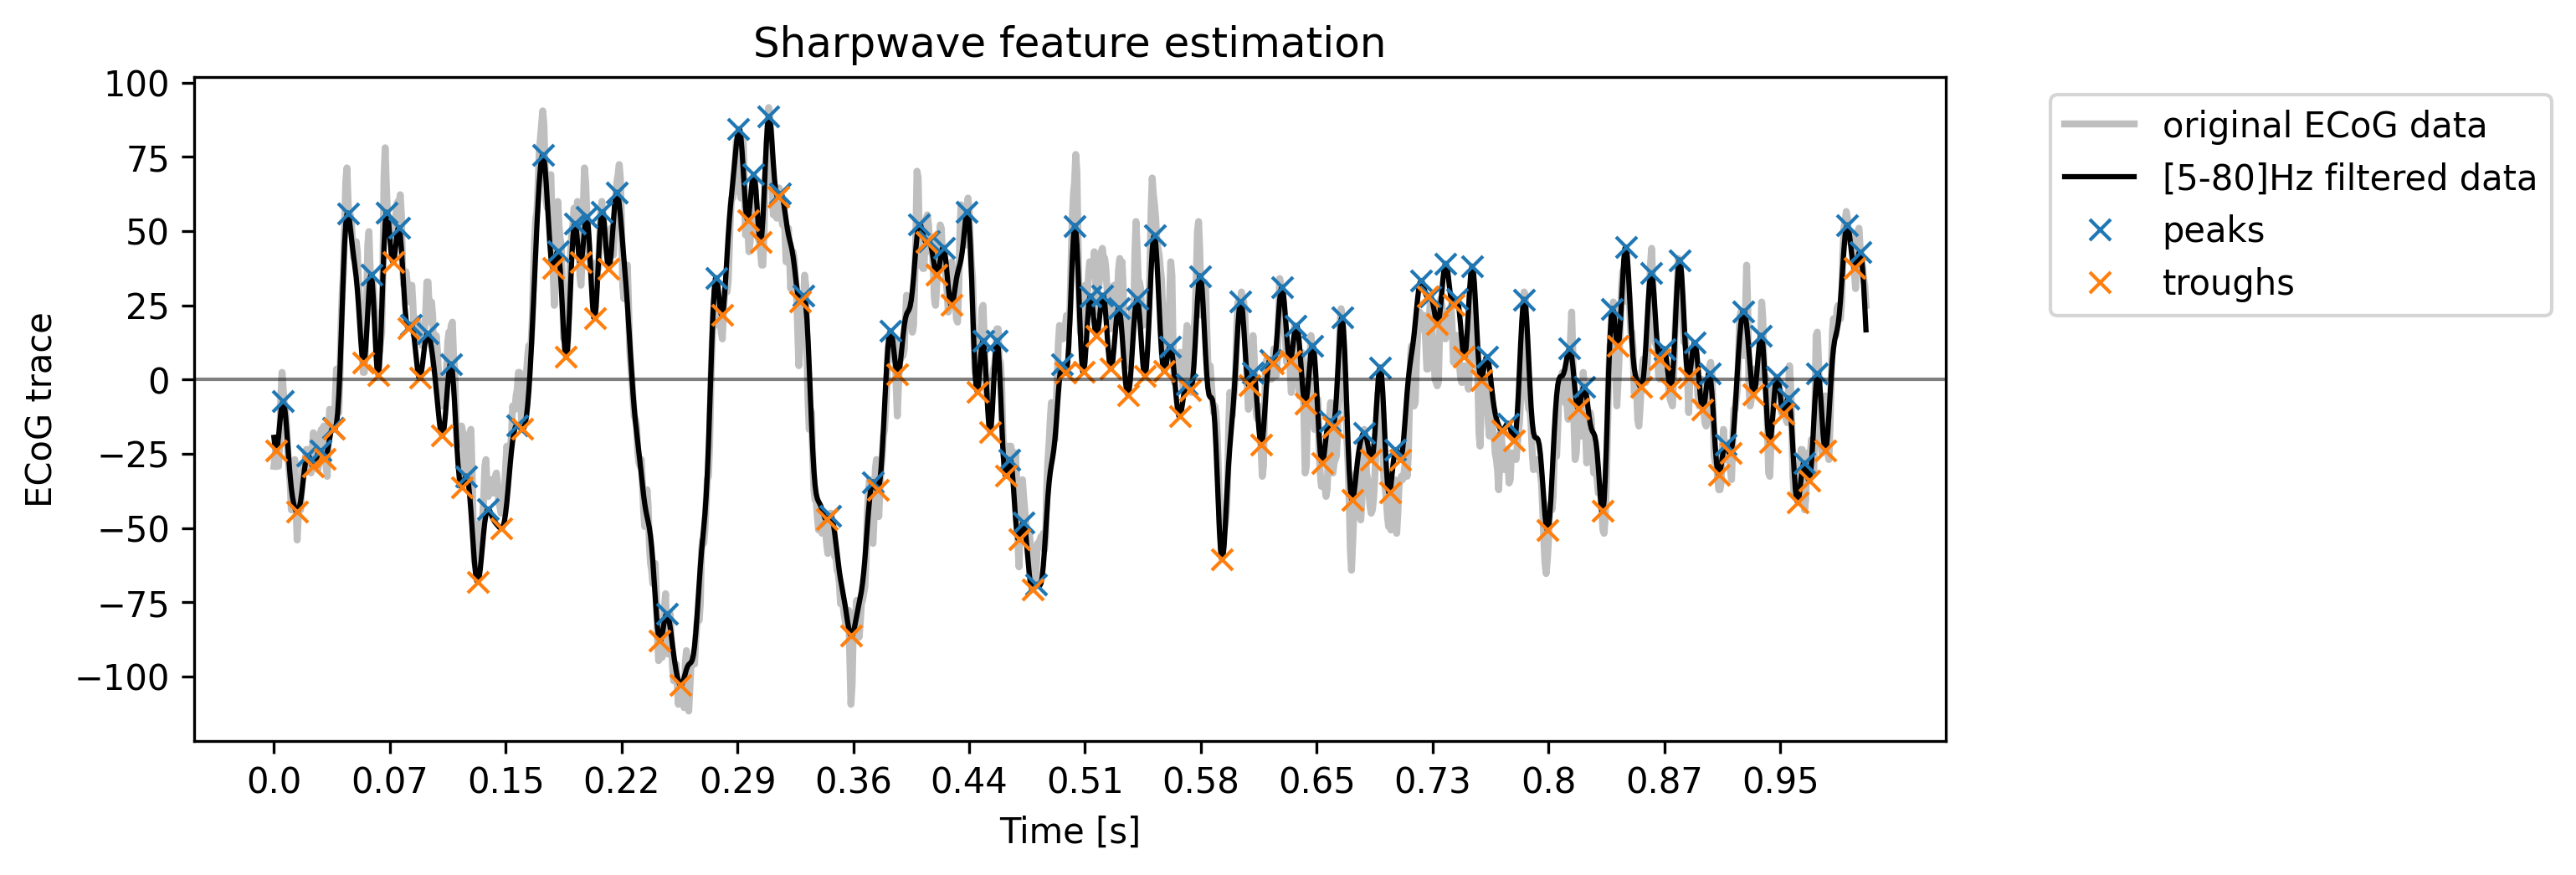

In [124]:
time_ = np.arange(0, raw_norm[5,:].shape[0], 1)/1375
plt.figure(figsize=(9,3.5), dpi=300)
plt.plot(raw_norm[5,:], color="gray", linewidth=2, alpha=0.5, label="original ECoG data")
plt.plot(filtered_data, color="black", label="[5-80]Hz filtered data")
plt.plot(peaks, filtered_data[peaks], "x", label="peaks")
plt.plot(troughs, filtered_data[troughs], "x", label="troughs")
#plt.bar(troughs[1:], run_analysis_.features.sw_features.sharpness, width=4, color="red",
#       label="trough sharpness", alpha=0.5)
plt.axhline(0, linewidth=1, color="black", alpha=0.5)
plt.xticks(np.arange(0, 1375, 100), np.round(np.arange(0, 1375, 100)/1375,2))
plt.xlabel("Time [s]")
plt.ylabel("ECoG trace")
plt.title("Sharpwave feature estimation")
plt.legend(bbox_to_anchor=(1.05, 1))

As seen above this sharpness characteristic is a useful feature for any decoding analysis, and might represent additional signal decoding characteristics. Since in one data batch a different number of peaks and troughs can be detected, the returning feature_arr included features of certain predefined operations on these sharpwave characteristics within this batch. Those are defined in the "estimator" key:

In [25]:
run_analysis_.settings["sharpwave_analysis_settings"]

{'sharpwave_features': {'peak_left': True,
  'peak_right': True,
  'trough': True,
  'width': True,
  'prominence': True,
  'interval': True,
  'decay_time': True,
  'rise_time': True,
  'sharpness': True,
  'rise_steepness': True,
  'decay_steepness': True,
  'slope_ratio': True},
 'filter_low_cutoff': 5,
 'filter_high_cutoff': 90,
 'detect_troughs': {'estimate': True,
  'distance_troughs': 5,
  'distance_peaks': 1},
 'detect_peaks': {'estimate': True,
  'distance_troughs': 1,
  'distance_peaks': 5},
 'estimator': {'mean': True,
  'median': True,
  'max': True,
  'min': True,
  'var': True}}

E.g. in this example the median, max, min and variance of all sharpness features would be returned. 